## Setup
Begin by installing and importing some necessary libraries

#### The way this tutorial uses the `TimeDistributed` layer requires TF>=2.10
pip install -U "tensorflow>=2.10.0"

pip install remotezip tqdm opencv-python
pip install -q git+https://github.com/tensorflow/docs

pip install imageio

import imageio

pip install scikit-learn

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
from sklearn.preprocessing import LabelEncoder

import cv2 # process video files

import imageio
from tensorflow_docs.vis import embed #for embedding data in a Jupyter notebook
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import math

## Download dataset



In [10]:
# folder path that you store the video file and csv file
dataset_file_path = "C:/Users/kwjia/Desktop/"

dataset_filepath = dataset_file_path+"final_exam/input_data_new.csv"
df = pd.read_csv(dataset_filepath)

## Create frames from each video file



Using pandas library to process dataframe and return to the seconds.

In [11]:
def convert_time_to_seconds(time_str):
    h, m, s = map(int, time_str.split(':'))
    return h * 3600 + m * 60 + s

df["start_time_seconds"]=df["Start_Time"].apply(convert_time_to_seconds)
df["end_time_seconds"]=df["End_Time"].apply(convert_time_to_seconds)
class_list = df.Movement_Name.unique()

<h2>Split video into train and test data</h2>

Split the data into train and test dataset based on the video rather than the motion

In [12]:
import random

# Set a specific seed value (for example, 42)
random.seed(42)

# get unique video from the dataset
video_list = df.File_Path.unique()

train_split_ratio = 0.8
random.shuffle(video_list)

split_idx = int(len(video_list) * train_split_ratio)

# Split video into train and test sets
train_videos_list = video_list[:split_idx]
test_videos_list = video_list[split_idx:]


<h2>Extract frame from video</h2>

Extract frame and video preprocessing process (frame skipping, frame resize, frame color code conversion, color code normalization)

In [13]:
#Extract frame from video
def extract_frame(path,start_time,end_time):
  frame_list = []
  SEQUENCE_LENGTH = 24

  # Open the video file for reading
  video_reader = cv2.VideoCapture(path)

  # Get the frames per second (fps), start_frame, and end_frame for the specified video duration
  fps = int(video_reader.get(cv2.CAP_PROP_FPS))
  frame_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  start_frame = int(start_time*fps)
  end_frame = int(end_time*fps)
  interval_frame = end_frame - start_frame

  #calculate the skip frame number formula total duration of interval frame / sequence length
  skip_frame_window = max(interval_frame/SEQUENCE_LENGTH,1)

  # Get the height and width of the video frames
  height = video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT)
  width = video_reader.get(cv2.CAP_PROP_FRAME_WIDTH)
  print(f'fps:{fps}, frame_cnt:{frame_count} interval_frame:{interval_frame}, height:{height}, width:{width}, start_frame:{start_frame},end_frame:{end_frame},skip:{skip_frame_window}')


  # Set the video reader to the start frame
  video_reader.set(cv2.CAP_PROP_POS_FRAMES,start_frame)
  current_frame = start_frame

  # Iterate through frames in the specified interval
  while video_reader.isOpened() and math.ceil(current_frame) < end_frame:
    ret, frame = video_reader.read()
    if not ret:
      break

    # Convert the frame from BGR to RGB
    frame_rgb_opencv = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Resize the frame to a specific size (720x1280)
    resized_frame = cv2.resize(frame_rgb_opencv,(128,128))

    #normalize data to [0,1]
    frame = tf.image.convert_image_dtype(resized_frame, tf.float32)
      
    # Append the resized frame to the frame_list
    frame_list.append(frame)

    # Set the video reader to the next frame position
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, int(current_frame + skip_frame_window) )

    # Increment the current_frame by skip_frame_window
    current_frame += skip_frame_window


  # Release the video reader and close any remaining OpenCV windows
  video_reader.release()
  cv2.destroyAllWindows()
    
  # Return the list of extracted frames
  return frame_list;

Generate input data as X and label as Y

In [14]:
X_train = [] #Save the frame
Y_train = [] #Save the label
X_test = [] #Save the frame
Y_test = [] #Save the label

for index,row in df.iterrows():
    start_time = row["start_time_seconds"]
    end_time = row["end_time_seconds"]
    path = dataset_file_path + row["File_Path"] # Get the vidoe file path
    label = row["Movement_Name"] # Get the Movement lable
    video_path = row["File_Path"]
   
    if video_path in train_videos_list:
        Y_train.append(np.where(class_list == label)[0][0])
        frame_list = extract_frame(path,start_time,end_time)
        X_train.append(np.asarray(frame_list))
    else:
        Y_test.append(np.where(class_list == label)[0][0])
        frame_list = extract_frame(path,start_time,end_time)
        X_test.append(np.asarray(frame_list))

#encode the label by using one-hot encoded
one_hot_encoded_labels_train = to_categorical(Y_train)
Y_train = one_hot_encoded_labels_train

one_hot_encoded_labels_test = to_categorical(Y_test)
Y_test = one_hot_encoded_labels_test
    

fps:30, frame_cnt:1538 interval_frame:150, height:360.0, width:204.0, start_frame:330,end_frame:480,skip:6.25
fps:30, frame_cnt:1538 interval_frame:120, height:360.0, width:204.0, start_frame:570,end_frame:690,skip:5.0
fps:30, frame_cnt:1538 interval_frame:150, height:360.0, width:204.0, start_frame:840,end_frame:990,skip:6.25
fps:15, frame_cnt:931 interval_frame:75, height:480.0, width:640.0, start_frame:330,end_frame:405,skip:3.125
fps:30, frame_cnt:5991 interval_frame:600, height:720.0, width:1280.0, start_frame:1950,end_frame:2550,skip:25.0
fps:30, frame_cnt:5991 interval_frame:240, height:720.0, width:1280.0, start_frame:3960,end_frame:4200,skip:10.0
fps:15, frame_cnt:526 interval_frame:180, height:720.0, width:1280.0, start_frame:30,end_frame:210,skip:7.5
fps:23, frame_cnt:6078 interval_frame:69, height:240.0, width:320.0, start_frame:414,end_frame:483,skip:2.875
fps:23, frame_cnt:6078 interval_frame:92, height:240.0, width:320.0, start_frame:1081,end_frame:1173,skip:3.8333333333

Visualise the frames for the specific video

In [15]:
def to_gif(images):
  converted_images = np.clip(images*255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=10)
  return embed.embed_file('./animation.gif')


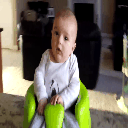

In [16]:
to_gif(X_train[1])

<h2>Train Data Augmentation</h2>

Since the original dataset size is small which may affect the model training performance, data augmentation will help to generate data with some transformation (flip and brightness adjustment)

In [17]:
def data_augmentation_flip_bright(X_train,Y_train):
    X_train_aug = []
    Y_train_aug = []

    for frame_list in X_train:
        frame_list_aug = []
        for frame in frame_list:
            flipped_frame = cv2.flip(frame,1)
            
            brightness_increase = 70/255
            brightened_frame = np.where((1 - flipped_frame) < brightness_increase, 1, flipped_frame + brightness_increase)
            
            frame_list_aug.append(brightened_frame)
        X_train_aug.append(np.asarray(frame_list_aug))

    for label in Y_train:
        Y_train_aug.append(label)
        
    return X_train_aug,Y_train_aug


In [18]:
X_train_aug,Y_train_aug = data_augmentation_flip_bright(X_train,Y_train)

In [19]:
augmented_img = np.clip(X_train_aug[2][1]*255, 0, 255).astype(np.uint8)

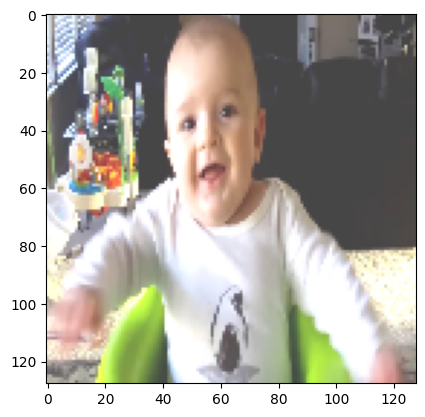

In [20]:
 plt.imshow(augmented_img)

In [21]:
ori_img = np.clip(X_train[2][1]*255, 0, 255).astype(np.uint8)

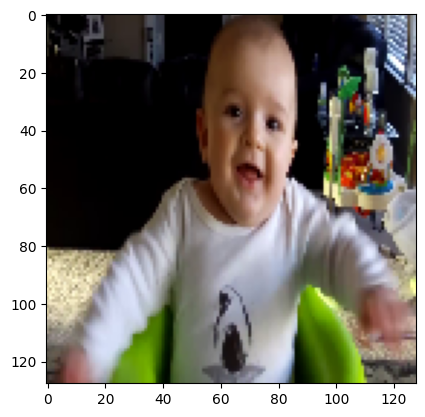

In [22]:
plt.imshow(ori_img)

In [23]:
X_train_aug = np.array([np.array(frame_list) for frame_list in X_train_aug])
X_train = np.append(X_train, X_train_aug, axis=0)
Y_train = np.append(Y_train, Y_train_aug, axis=0)

# Construct Model - Using tensorflow

In [25]:
import torchvision.models as models
import keras.models as kmodels
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
import tensorflow.keras as keras 

keras.utils.set_random_seed(42)
np.random.seed(42)
tf.random.set_seed(42)

def create_convlstm_model():
  model = Sequential()
  model.add(ConvLSTM2D(filters=4, kernel_size=(3, 3), activation='tanh',
                       recurrent_dropout=0.2, data_format = "channels_last", return_sequences=True, input_shape=(24,128,128,3)))
  model.add(MaxPooling3D(pool_size=(1,2,2),padding='same', data_format = "channels_last"))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3), activation='tanh',
                       recurrent_dropout=0.2, data_format = "channels_last", return_sequences=True))
  model.add(MaxPooling3D(pool_size=(1,2,2),padding='same', data_format = "channels_last"))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters=14, kernel_size=(3, 3), activation='tanh',
                       recurrent_dropout=0.2, data_format = "channels_last", return_sequences=True))
  model.add(MaxPooling3D(pool_size=(1,2,2),padding='same', data_format = "channels_last"))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='tanh',
                       recurrent_dropout=0.2, data_format = "channels_last", return_sequences=True))
  model.add(MaxPooling3D(pool_size=(1,2,2),padding='same', data_format = "channels_last"))

  model.add(Flatten())
  model.add(Dense(units=class_list.size, activation='softmax'))

  model.summary()

  return model

In [26]:
convlstm_model = create_convlstm_model()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 24, 126, 126, 4)   1024      
                                                                 
 max_pooling3d (MaxPooling3  (None, 24, 63, 63, 4)     0         
 D)                                                              
                                                                 
 time_distributed (TimeDist  (None, 24, 63, 63, 4)     0         
 ributed)                                                        
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 24, 61, 61, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 24, 31, 31, 8)     0         
 g3D)                                                            
                                                       

In [27]:
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras as keras 

In [28]:
early_stopping_callback = EarlyStopping(monitor='val_loss',patience=10,mode='min',restore_best_weights=True)

convlstm_model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

X_train_tensor = tf.convert_to_tensor(X_train)

convlstm_model_training_history = convlstm_model.fit(x=X_train_tensor,y = Y_train,epochs = 50, batch_size=4,shuffle=True,
                                                     validation_split = 0.2, callbacks=[early_stopping_callback])


Epoch 1/50


22/22 [==============================] - 36s 874ms/step - loss: 0.7143 - accuracy: 0.5349 - val_loss: 0.8246 - val_accuracy: 0.2727
Epoch 2/50
22/22 [==============================] - 19s 845ms/step - loss: 0.6904 - accuracy: 0.6047 - val_loss: 0.7141 - val_accuracy: 0.2727
Epoch 3/50
22/22 [==============================] - 18s 822ms/step - loss: 0.6668 - accuracy: 0.5814 - val_loss: 0.8397 - val_accuracy: 0.2727
Epoch 4/50
22/22 [==============================] - 18s 825ms/step - loss: 0.6498 - accuracy: 0.6860 - val_loss: 0.5997 - val_accuracy: 0.7727
Epoch 5/50
22/22 [==============================] - 18s 836ms/step - loss: 0.8224 - accuracy: 0.6977 - val_loss: 0.6925 - val_accuracy: 0.5455
Epoch 6/50
22/22 [==============================] - 18s 824ms/step - loss: 0.5640 - accuracy: 0.7791 - val_loss: 0.8819 - val_accuracy: 0.3182
Epoch 7/50
22/22 [==============================] - 19s 856ms/step - loss: 0.5452 - accuracy: 0.7558 - val_loss: 0.6812 - val_accuracy: 0.5

In [29]:
X_test_tensor = tf.convert_to_tensor(X_test)
model_evaluation_history = convlstm_model.evaluate(X_test_tensor,Y_test)

1/1 [==============================] - 0s 490ms/step - loss: 0.4725 - accuracy: 0.7059


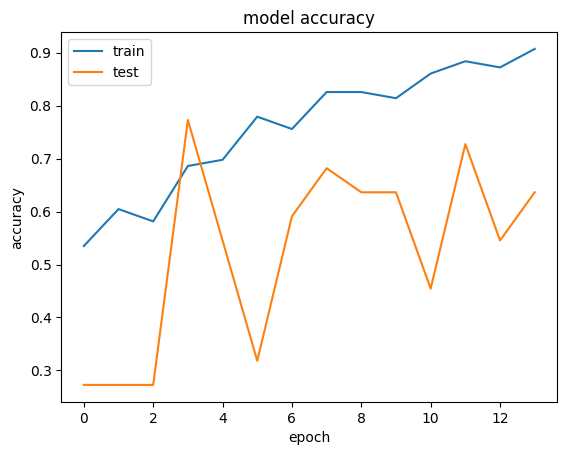

In [30]:
# summarize history for accuracy
plt.plot(convlstm_model_training_history.history['accuracy'])
plt.plot(convlstm_model_training_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

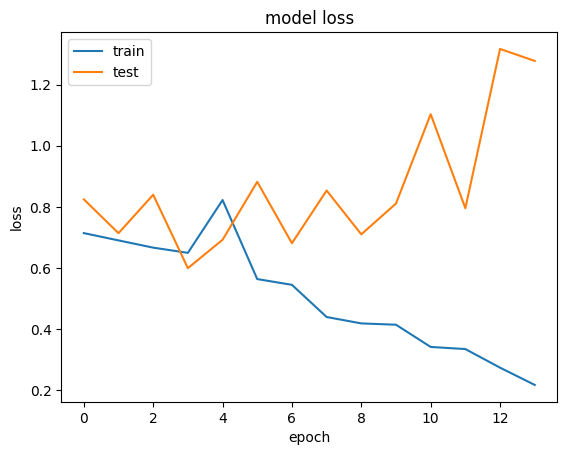

In [31]:
# summarize history for loss
plt.plot(convlstm_model_training_history.history['loss'])
plt.plot(convlstm_model_training_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()